In [1]:
import numpy as np 
import tensorly as tl
import sys
sys.path.append("../mfda/")
from tensor_decomposition import MARGARITA, fCP_TPA_GCV
from hyperparam_selection import tfold_cross_val
from marginal_product_basis import MPB
from utility import FPCA, discrete_laplacian_1D
from skfda.preprocessing.smoothing import BasisSmoother
from skfda.representation.basis import Fourier, BSpline, Tensor
from skfda.misc.operators import LinearDifferentialOperator, gram_matrix
from skfda.preprocessing.smoothing import BasisSmoother
from skfda import FDataGrid

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import KFold
from collections import namedtuple 
import time 
import os 
import itertools 
import pickle 
import scipy 
from scipy.stats import ortho_group, sem
import pandas as pd 
import functools 
import operator 

import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib import cm
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

svdtuple = namedtuple("SVD", ["U", "s", "Vt"])
DATA_DIR = "data"

%load_ext autoreload
%autoreload 2

In [2]:
## set common optimization parameters 
maxiter = (200, 100)
tol_inner = (1e-3, 1e-3)
tol_outer = 1e-3
initialize = "random"

####UTILITY FUNCTIONS#####
def kompb(Y, K, pen_params, reg_type="l2"):
    ## Compute basis evaluation matrices and SVDs
    Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
    ## Perform the n-mode coordinate transformations into the spline coefficient space 
    ## Y_Bar should be close to zero so no need to center 
    G = tl.tenalg.multi_mode_dot(Y, [svdt.U.T for svdt in Svds], list(range(nmode)))
    Vs = [Svds[d].Vt.T for d in range(nmode)]
    Dinvs = [np.diag(1./Svds[d].s) for d in range(nmode)]
    Tlst_bcd = [Dinvs[d]@Vs[d].T@Rlst[d]@Vs[d]@Dinvs[d] for d in range(nmode)]
    start = time.time()
    Ctilde, Smat, scalars, FLAG_C, FLAG_N = MARGARITA(G, Tlst_bcd, pen_params, K, 
                                     max_iter=maxiter, tol_inner=tol_inner, 
                                     tol_outer=tol_outer,  regularization=reg_type, init=initialize, 
                                    verbose=False)
    elapsed = time.time() - start
    Clst = [Svds[d].Vt.T @ np.diag(1/Svds[d].s) @ Ctilde[d] for d in range(nmode)] 
    Smat_scaled = np.multiply(Smat, scalars)
    Zeta_tensor = np.zeros(tuple([K] + list(Y.shape[:-1])))
    for k in range(K):
        Zeta_tensor[k,...] = np.prod(np.ix_(*[Phis[d] @ Clst[d][:,k] for d in range(nmode)]))
    return Zeta_tensor, Clst, Ctilde, Smat_scaled 

####UTILITY METRICS####
def MISE_evaluation(Clst_true, Coef_true, basis_true, K_true, Jlst_true, Jlst_cross,
                    Clst_repr, basis_repr, Smat_repr, K_repr, Jlst_repr): 
    N = Smat_repr.shape[0]
    MISE = np.zeros(N)
    for i in range(N):
        f2 = 0; g2 = 0; fg = 0
        for k in range(K_true):
            for j in range(K_true):
                f2 += Coef_true[i,k]*Coef_true[i,j]*np.prod([Clst_true[d][:,k:(k+1)].T@Jlst_true[d]@Clst_true[d][:,j:(j+1)]  
                                                   for d in range(3)])
        for k in range(K_repr):
            for j in range(K_repr):
                g2 += Smat_repr[i,k]*Smat_repr[i,j]*np.prod([Clst_repr[d][:,k:(k+1)].T@Jlst_repr[d]@Clst_repr[d][:,j:(j+1)]  
                                                   for d in range(3)]) 
        for k in range(K_true):
            for j in range(K_repr):
                fg += Coef_true[i,k]*Smat_repr[i,j]*np.prod([Clst_true[d][:,k:(k+1)].T@Jlst_cross[d]@Clst_repr[d][:,j:(j+1)]  
                                                   for d in range(3)])
        MISE[i] = f2 - 2*fg + g2
    return MISE

In [3]:
np.random.seed(15) ## make exactly reproducible 

## 3d domain
nds = (50, 50, 50)
nmode = len(nds)
xgrids = [np.linspace(0,1,nds[d]) for d in range(nmode)]

## define random-field from Section 5.1
K_t = 20 
alpha = 0.7
md_t = 11
true_basis = Fourier((0,1), n_basis=md_t, period=1)
basis_true = [true_basis for d in range(nmode)]

V = ortho_group.rvs(K_t)
Sigma_S = V @ np.diag(np.exp(-alpha*np.arange(0,K_t))) @ V.T
#Clst_t = [np.random.normal(loc=0.0, scale=1.0, size=(md_t, K_t)) for d in range(nmode)]
Clst_t = [np.random.normal(loc=0.0, scale=0.5, size=(md_t, K_t)) for d in range(nmode)]

def sample_field(N):
    ## Link replications together by common naming convention on the outname 
    Phis_t = [np.squeeze(true_basis.evaluate(xgrids[d])).T for d in range(nmode)]
    ## Sample random coefficients 
    Coefs_t = np.random.multivariate_normal(np.zeros(K_t), Sigma_S, N) ## N x K 
    ## Construct tensor basis system 
    tensor_lst = [np.prod(np.ix_(*[Phis_t[d]@Clst_t[d][:, k] for d in range(nmode)])) for k in range(K_t)]
    tensor_basis = np.zeros(tuple([K_t] + list(tensor_lst[0].shape)))
    for k in range(K_t):
        tensor_basis[k, ...] = tensor_lst[k]
    ## Simulate data 
    Y = np.zeros(tuple(list(nds)+[N]))
    for n in range(N):
        Y[..., n] = tl.tenalg.mode_dot(tensor_basis, Coefs_t[n,:], 0)
    return Y, Coefs_t  

def sample_field_sparse(N, nsparse=5):
    ## Link replications together by common naming convention on the outname 
    Phis_t = [np.squeeze(true_basis.evaluate(xgrids[d])).T for d in range(nmode)]
    ## Sample random coefficients 
    Coefs_t = np.random.multivariate_normal(np.zeros(K_t), Sigma_S, N) ## N x K 
    
    Coefs_t[:int(N/2), :nsparse] = np.zeros((int(N/2),nsparse))
    Coefs_t[int(N/2):, nsparse:(2*nsparse)] = np.zeros((N-int(N/2),nsparse))
    
    ## Construct tensor basis system 
    tensor_lst = [np.prod(np.ix_(*[Phis_t[d]@Clst_t[d][:, k] for d in range(nmode)])) for k in range(K_t)]
    tensor_basis = np.zeros(tuple([K_t] + list(tensor_lst[0].shape)))
    for k in range(K_t):
        tensor_basis[k, ...] = tensor_lst[k]
    ## Simulate data 
    Y = np.zeros(tuple(list(nds)+[N]))
    for n in range(N):
        Y[..., n] = tl.tenalg.mode_dot(tensor_basis, Coefs_t[n,:], 0)
    return Y, Coefs_t  

# Maginal Rank Selection

In [4]:
## simulation parameters 
Nrep = 100
Ntrain = 50
marg_ranks = [5, 10, 15, 20, 25, 30, 40, 50]

sigma2s = (0.5, 10)

results_marg_rank = []

for sigma2 in sigma2s:
    mar_var_estims = np.zeros((Nrep,len(marg_ranks)))
    for rep in range(Nrep):
        Y_true, _ = sample_field(Ntrain)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        for mi, mr in enumerate(marg_ranks):
            bspline_basis_mr = [BSpline(n_basis=mr, order=4) for d in range(nmode)]
            Phis_mr = [np.squeeze(bspline_basis_mr[d].evaluate(xgrids[d])).T for d in range(nmode)]
            Svds = [svdtuple(*np.linalg.svd(Phis_mr[d], full_matrices=False)) for d in range(nmode)]
            G_mr = tl.tenalg.multi_mode_dot(Y_noisey, [svdt.U.T for svdt in Svds], list(range(nmode)))
            mar_var_estims[rep, mi] = tl.norm(G_mr)**2/tl.norm(Y_noisey)**2
    results_marg_rank.append(mar_var_estims)

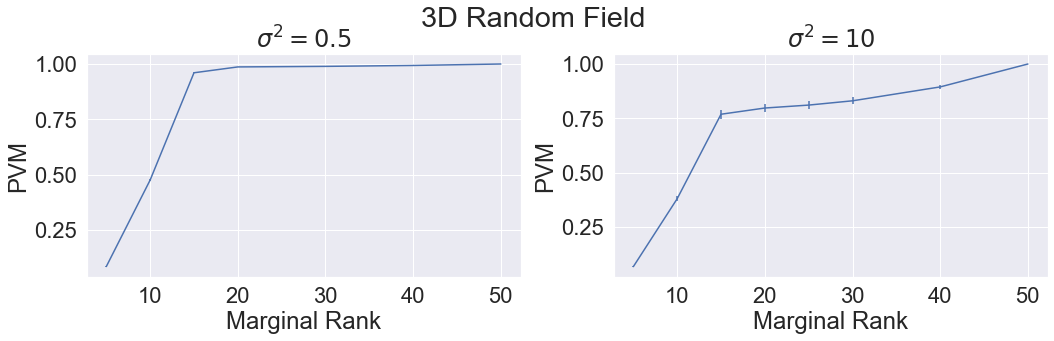

In [5]:
sns.set(font_scale = 2)

f, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].errorbar(marg_ranks, np.mean(results_marg_rank[0], axis=0), yerr=np.std(results_marg_rank[0], axis=0))
ax[0].set_xlabel("Marginal Rank")
ax[0].set_ylabel("PVM")
ax[0].set_title(r'$\sigma^2=%s$'%sigma2s[0])

ax[1].errorbar(marg_ranks, np.mean(results_marg_rank[1], axis=0), yerr=np.std(results_marg_rank[1], axis=0))
ax[1].set_xlabel("Marginal Rank")
ax[1].set_ylabel("PVM")
ax[1].set_title(r'$\sigma^2=%s$'%sigma2s[1])

## clear elbow at m = 15
m1, m2, m3 = 15, 15, 15
mds_fit = (m1, m2, m3)

plt.suptitle("3D Random Field")
f.tight_layout()

#plt.savefig("../../figures/sim_51_margrank_Kt20.pdf")

# Global Rank Selection

In [6]:
## Global parameters 
bspline_basis = [BSpline(n_basis=mds_fit[d], order=4) for d in range(nmode)] 
Phis = [np.squeeze(bspline_basis[d].evaluate(xgrids[d])).T for d in range(nmode)]
Svds = [svdtuple(*np.linalg.svd(Phis[d], full_matrices=False)) for d in range(nmode)]
## Specify differential operator for penalization 
D2 = LinearDifferentialOperator(2)
Rlst = [gram_matrix(D2, bspline_basis[d]) for d in range(nmode)] 

## simulation parameters 
results_global_rank = []
pen_params = (1e-10, 1e-10, 1e-10, 1e-10) ## fix for rank selection

Ks = [3, 5, 10, 15, 20, 25, 30]
results_global_rank = []

PVE_thresh = 0.995
K_select_results = {}
for sigma2 in sigma2s:
    glob_var_estims = np.zeros((Nrep,len(Ks)))
    Kselcted = np.zeros(Nrep)
    for rep in range(Nrep):
        Y_true, _ = sample_field(Ntrain)
        Y_noisey = Y_true + np.random.normal(loc=0, scale=np.sqrt(sigma2), size=Y_true.shape)
        G = tl.tenalg.multi_mode_dot(Y_noisey, [svdt.U.T for svdt in Svds], list(range(nmode)))
        for ki, K in enumerate(Ks):
            pvg = []
            Zeta_tensor, Clst, Ctilde, Smat_scaled = kompb(Y_noisey, K, pen_params, reg_type="l2")
            Ghat = np.zeros(tuple(list(mds_fit) + [Ntrain]))
            for k in range(K):
                Ghat = Ghat + np.prod(np.ix_(*[Ctilde[d][:, k] for d in range(nmode)]+[Smat_scaled[:,k]]))
            glob_var_estims[rep,ki] = tl.norm(Ghat)**2/tl.norm(G)**2
        try: 
            Kselcted[rep] = Ks[np.where(glob_var_estims[rep,:]>PVE_thresh)[0][0]]
        except:
            Kselcted[rep] = Ks[-1]
    K_select_results[sigma2] = int(np.mean(Kselcted))
    results_global_rank.append(glob_var_estims)

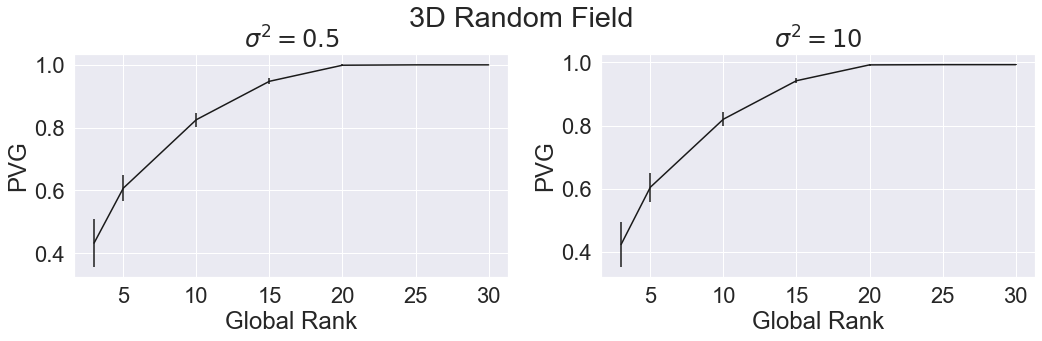

In [7]:
f, ax = plt.subplots(1,2, figsize=(15,5))

ax[0].errorbar(Ks, np.mean(results_global_rank[0], axis=0), yerr=np.std(results_global_rank[0], axis=0),
              color="k")
ax[0].set_xlabel("Global Rank")
ax[0].set_ylabel("PVG")
ax[0].set_title(r'$\sigma^2=%s$'%sigma2s[0])

ax[1].errorbar(Ks, np.mean(results_global_rank[1], axis=0), yerr=np.std(results_global_rank[1], axis=0),
               color="k")
ax[1].set_xlabel("Global Rank")
ax[1].set_ylabel("PVG")
ax[1].set_title(r'$\sigma^2=%s$'%sigma2s[1])

plt.suptitle("3D Random Field")

f.tight_layout()

#plt.savefig("../../figures/sim_51_globrank_Kt20_noline.pdf")